In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [5]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


initialize gmm using k-means++ (recommended and faster than k-means)

In [6]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [7]:
initial_gmm = init_gmm.initial_gaussian_mixtures('..', sub_id, trials, n_gaussians=400, seed=seed, fit_model=False)

In [8]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

In [9]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, initial_labels, initial_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 400, 30)
clusterless neural projections shape: (230, 400, 15)
clusterless neural reconstructions shape: (230, 400, 30)


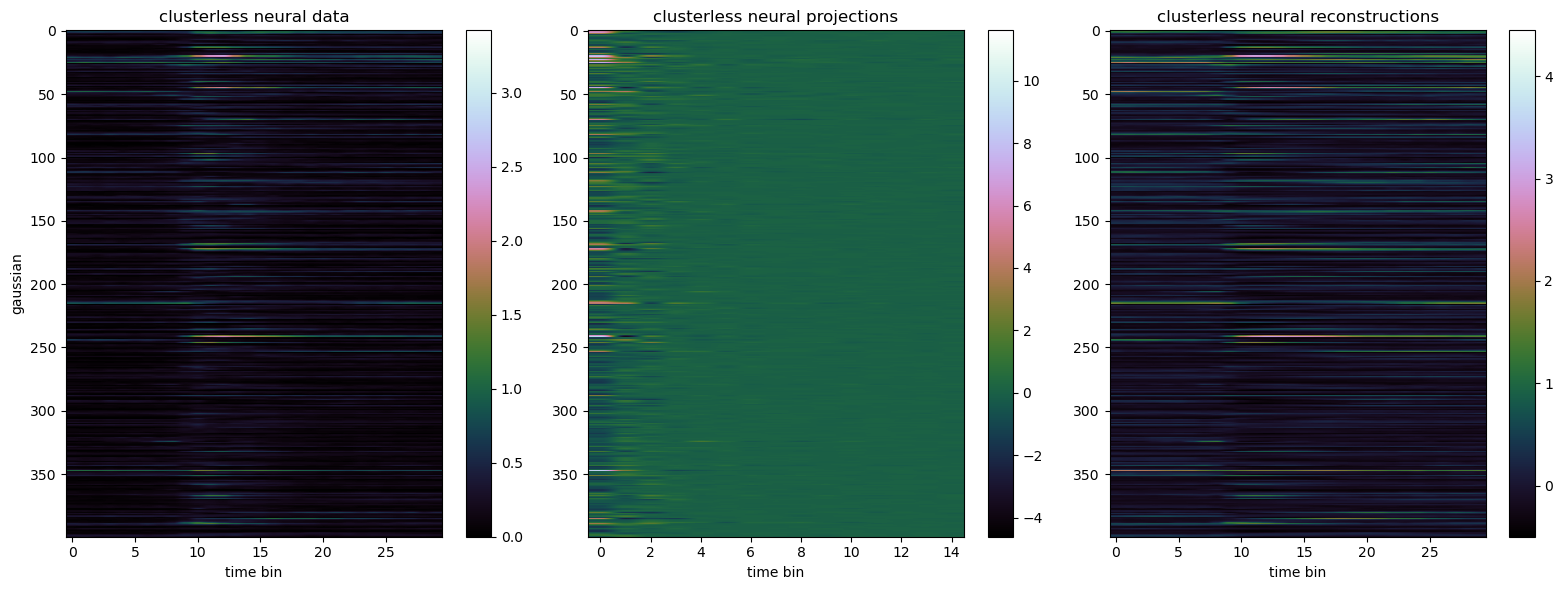

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [11]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.985
choice fold 2 test accuracy: 0.957 auc: 0.981
choice fold 3 test accuracy: 0.957 auc: 0.992
choice fold 4 test accuracy: 0.935 auc: 0.982
choice fold 5 test accuracy: 0.978 auc: 1.000
choice mean of 5-fold cv accuracy: 0.948 auc: 0.988
choice sd of 5-fold cv accuracy: 0.022 auc: 0.007
stimulus fold 1 test accuracy: 0.261 auc: 0.785
stimulus fold 2 test accuracy: 0.239 auc: 0.790
stimulus fold 3 test accuracy: 0.391 auc: 0.828
stimulus fold 4 test accuracy: 0.261 auc: 0.800
stimulus fold 5 test accuracy: 0.370 auc: 0.815
stimulus mean of 5-fold cv accuracy: 0.304 auc: 0.804
stimulus sd of 5-fold cv accuracy: 0.063 auc: 0.016


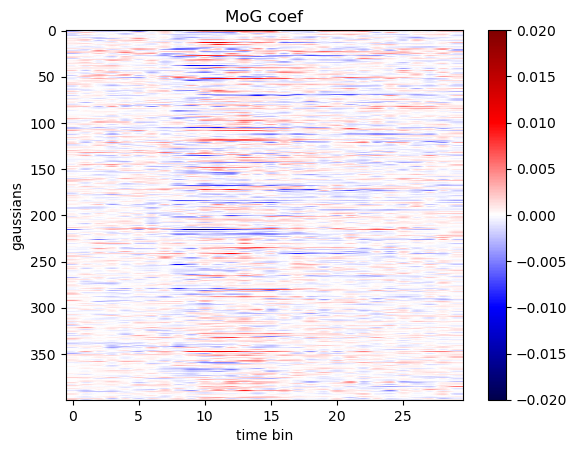

In [14]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()

split with bayesian dirichlet process:
1. find gaussians to be split
2. fit bayesian gmm on identified gaussians to automatically decide K
3. check if feature MAD of new gaussians satisfy the split criteria
4. go back to step 1 and repeat for gaussians to be split
5. repeat till no gaussians need to be split according to the criteria

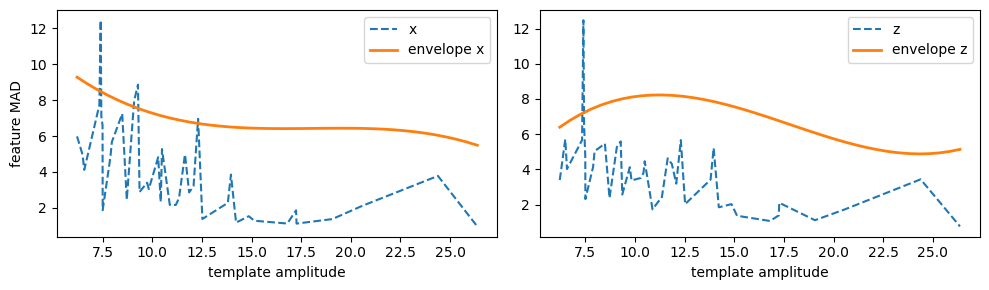

94 306


In [9]:
# plot smooth envelope for kilosort template feature MADs
split_ids, residual_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)
print(len(split_ids), len(residual_ids))

now visualize gaussians to be split ...

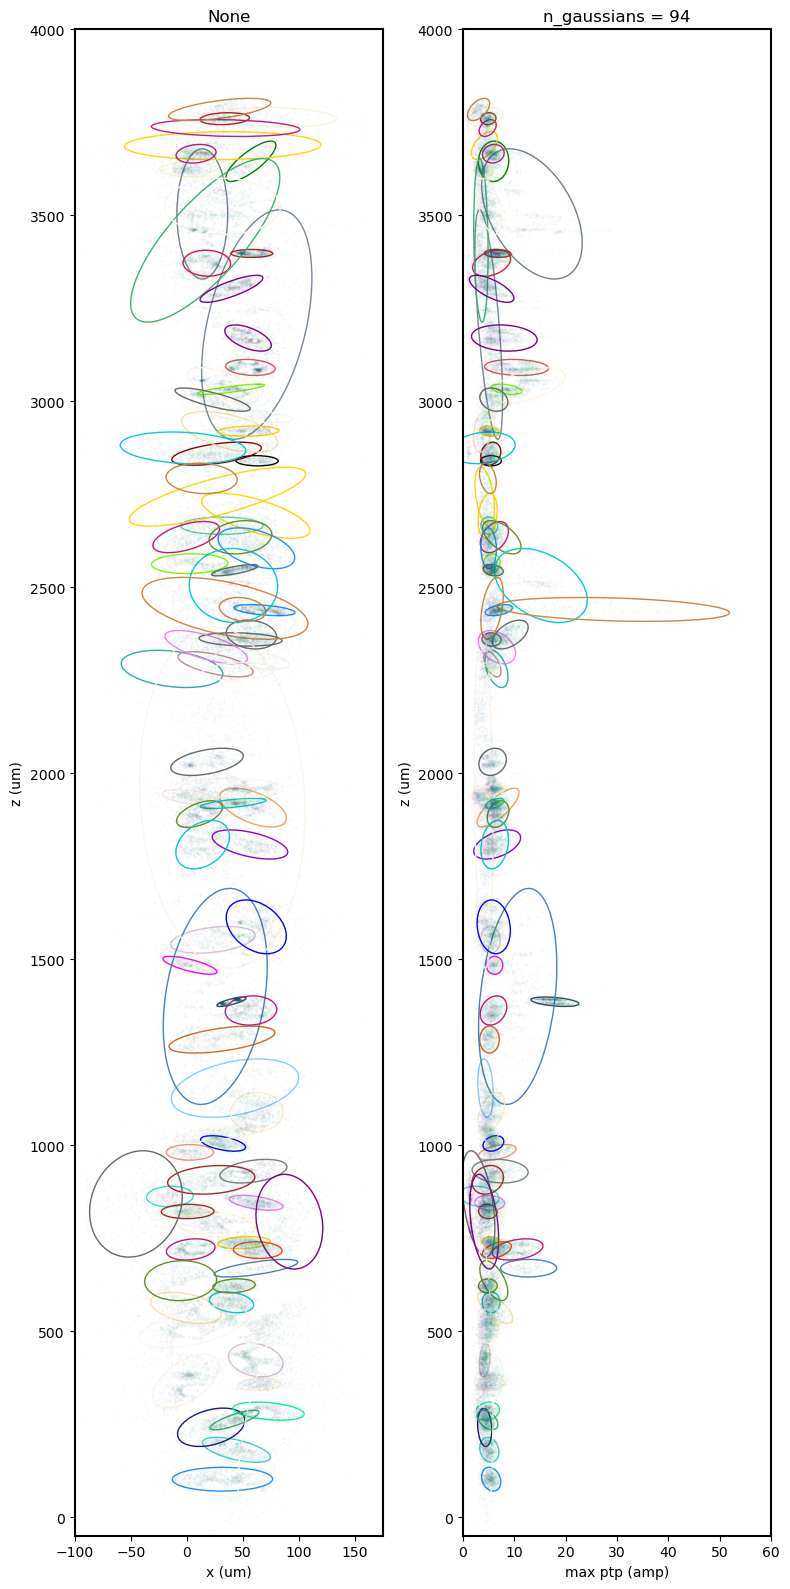

In [10]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, split_ids, display_all_spikes=False, n_spikes_display=1_000)

then visualize gaussians to be kept ...

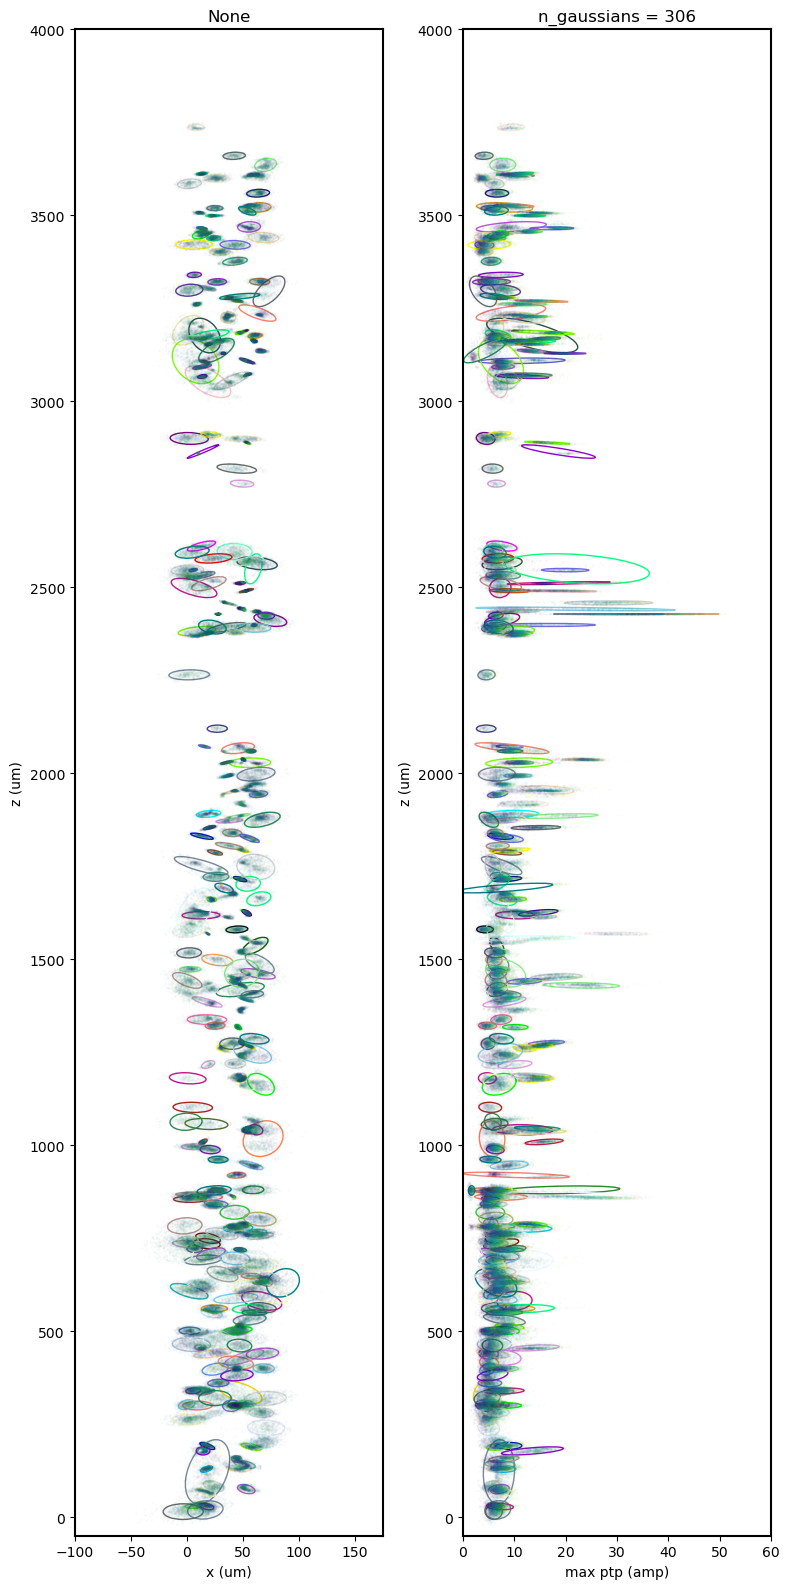

In [11]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, residual_ids, display_all_spikes=False, n_spikes_display=1_000)

zoom into one gaussian to investigate ...

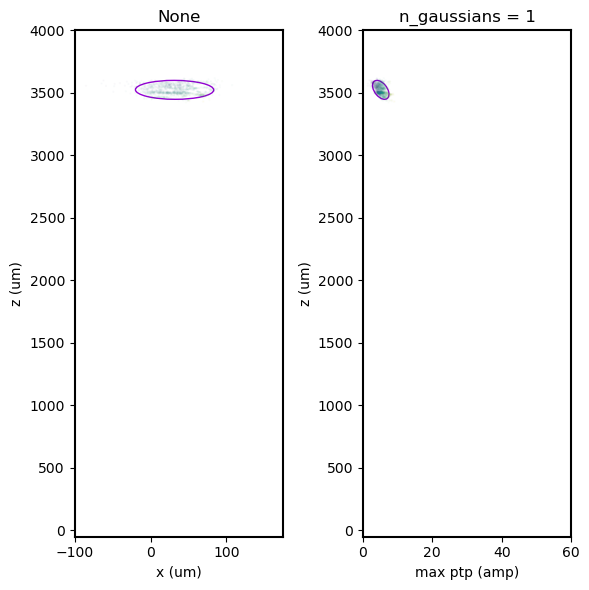

In [21]:
idx = -10
sub_spikes_train = structured_unsorted[initial_labels == split_ids[idx]]
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, split_ids[idx], display_all_spikes=True, figure_size=(6,6))

this gaussian has large variances ...

In [22]:
np.cov(sub_spikes_train.transpose())

array([[ 6.68489207e+02, -1.46093774e+01,  1.09440914e+01],
       [-1.46093774e+01,  1.43174358e+03, -2.08230606e+01],
       [ 1.09440914e+01, -2.08230606e+01,  1.40263627e+00]])

use an empirical prior for the covariance matrix to fit bayesian gmm ...

In [23]:
residual_vars = np.vstack([np.var(structured_unsorted[initial_labels == i], axis=0) for i in residual_ids])
empirical_cov_prior = np.zeros((3, 3))
empirical_cov_prior[range(3), range(3)] = np.mean(residual_vars, axis=0)

In [24]:
empirical_cov_prior

array([[32.22747865,  0.        ,  0.        ],
       [ 0.        , 63.91218015,  0.        ],
       [ 0.        ,  0.        ,  4.21309855]])

In [30]:
# use dirichlet process to choose K for each gaussian to be split
from sklearn.mixture import BayesianGaussianMixture
tmp_gmm = BayesianGaussianMixture(n_components=2, 
                          max_iter=2000,
                          n_init=2,
                          init_params='kmeans',
                          warm_start=True, verbose=1, verbose_interval=50,
                          weight_concentration_prior_type='dirichlet_process',
                          covariance_prior=empirical_cov_prior)
tmp_gmm.fit(sub_spikes_train)

Initialization 0
Initialization converged: True
Initialization 1
Initialization converged: True


BayesianGaussianMixture(covariance_prior=array([[32.22747865,  0.        ,  0.        ],
       [ 0.        , 63.91218015,  0.        ],
       [ 0.        ,  0.        ,  4.21309855]]),
                        max_iter=2000, n_components=2, n_init=2, verbose=1,
                        verbose_interval=50, warm_start=True)

look at the splitted gaussians ...

In [31]:
tmp_labels = tmp_gmm.predict(sub_spikes_train)
tmp_probs = tmp_gmm.predict_proba(sub_spikes_train)

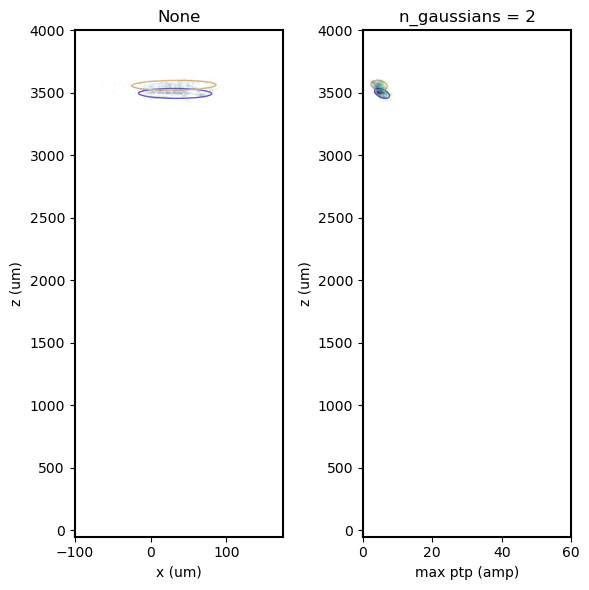

In [32]:
viz_tools.plot_gmm_cluster_bounds(sub_id, sub_spikes_train, tmp_labels, tmp_labels, figure_size=(6,6), display_all_spikes=True)

the goal is to keep spliting till no gaussians fall above the envelope ...

now iterate to do so ...

first put aside residuals gaussians that we want to keep ...

In [33]:
residual_ids = set(np.unique(initial_labels)).difference(set(split_ids))
print(f'keep {len(residual_ids)} gaussians and split {len(split_ids)} gaussians ...')

residual_weights = np.vstack([initial_gmm.weights_[i] for i in residual_ids]).squeeze()
residual_means = np.vstack([initial_gmm.means_[i] for i in residual_ids])
residual_covariances = np.stack([initial_gmm.covariances_[i] for i in residual_ids])

residual_gmm = GaussianMixture(n_components=len(residual_ids), covariance_type='full')
residual_gmm.weights_ = residual_weights
residual_gmm.means_ = residual_means
residual_gmm.covariances_ = residual_covariances
residual_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(residual_covariances))

residual_spikes_train = np.vstack([structured_unsorted[initial_labels == idx] for idx in residual_ids])
residual_labels = residual_gmm.predict(residual_spikes_train)
n_total = structured_unsorted.shape[0]
residual_fractions = [sum(residual_labels == i)/n_total for i in np.unique(residual_labels)]

residual_vars = np.vstack([np.var(structured_unsorted[initial_labels == i], axis=0) for i in residual_ids])
empirical_cov_prior = np.zeros((3, 3))
empirical_cov_prior[range(3), range(3)] = np.mean(residual_vars, axis=0)

keep 306 gaussians and split 94 gaussians ...


In [34]:
# check what an average covariance matrix looks like 
np.trace(empirical_cov_prior)

100.35275734619472

In [51]:
# while feature MAD fall above the envelope, do:

weights_lst = []
means_lst = []
covs_lst = []
labels_lst = []

for idx in split_ids:
    sub_spikes_train = structured_unsorted[initial_labels == idx]
    trace = np.trace(np.cov(sub_spikes_train.transpose()))
        
    # choose K based on the size of an average covariance matrix
    n_components = int(trace // (3*np.trace(empirical_cov_prior)))+1
    if n_components > len(sub_spikes_train):
        n_components = len(sub_spikes_train)
        
    # temporarily dropping very large gaussians
    if trace > 10_000:
        n_components = 1
    
    # tmp_gmm = BayesianGaussianMixture(n_components=n_components, 
    #                       max_iter=2000,
    #                       n_init=1,
    #                       init_params='kmeans',
    #                       warm_start=True, verbose=0, 
    #                       weight_concentration_prior_type='dirichlet_process',
    #                       # covariance_type='diag')
    #                       covariance_prior=empirical_cov_prior)
    
    tmp_gmm = GaussianMixture(n_components=n_components, 
                          init_params='kmeans', random_state=seed,
                          warm_start=True, verbose=0, 
                          covariance_type='full')
    tmp_gmm.fit(sub_spikes_train)
    weights_lst.append(tmp_gmm.weights_)
    means_lst.append(tmp_gmm.means_)
    covs_lst.append(tmp_gmm.covariances_)
    labels = tmp_gmm.predict(sub_spikes_train)
    labels_lst.append(labels)

    print(f'split {idx} with trace {round(trace, 2)} into {len(np.unique(labels))} gaussians ...')

split 3 with trace 904.95 into 4 gaussians ...
split 5 with trace 885.5 into 3 gaussians ...
split 6 with trace 688.36 into 3 gaussians ...
split 29 with trace 424.31 into 2 gaussians ...
split 33 with trace 676.38 into 3 gaussians ...
split 34 with trace 292.34 into 1 gaussians ...
split 55 with trace 224.62 into 1 gaussians ...
split 56 with trace 137.42 into 1 gaussians ...
split 57 with trace 1140.91 into 4 gaussians ...
split 67 with trace 289.19 into 1 gaussians ...
split 68 with trace 473.06 into 2 gaussians ...
split 71 with trace 301.78 into 2 gaussians ...
split 72 with trace 290.29 into 1 gaussians ...
split 83 with trace 568.64 into 2 gaussians ...
split 90 with trace 863.37 into 3 gaussians ...
split 91 with trace 7811.04 into 26 gaussians ...
split 92 with trace 482.23 into 2 gaussians ...
split 95 with trace 247.87 into 1 gaussians ...
split 96 with trace 639.06 into 3 gaussians ...
split 103 with trace 511.48 into 2 gaussians ...
split 110 with trace 881.35 into 3 gauss

In [52]:
# to do: clean this up
# organize the results a bit to collapse everything into one MoG

fractions_lst = []
for labels in labels_lst:
    fractions = [sum(labels == i)/n_total for i in np.unique(labels)]
    fractions_lst.extend(fractions)
    
unique_means_lst = []
for i, means in enumerate(means_lst):
    labels = labels_lst[i]
    unique_means = [means[j] for j in np.unique(labels)]
    unique_means_lst.extend(unique_means)
    
unique_covs_lst = []
for i, covs in enumerate(covs_lst):
    labels = labels_lst[i]
    unique_covs = [covs[j] for j in np.unique(labels)]    # for cov_type = 'full'
    # unique_covs = [np.diag(covs[j]) for j in np.unique(labels)]  # for cov_type = 'diag'
    unique_covs_lst.append(unique_covs)

In [53]:
post_split_weights = np.hstack([residual_fractions, fractions_lst])
post_split_means = np.vstack([residual_means, np.vstack(unique_means_lst)])
post_split_covariances = np.vstack([residual_covariances, np.vstack(unique_covs_lst)])

post_split_gmm = GaussianMixture(n_components=len(post_split_weights), covariance_type='full')
post_split_gmm.weights_ = post_split_weights
post_split_gmm.means_ = post_split_means
post_split_gmm.covariances_ = post_split_covariances
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(post_split_covariances))

In [56]:
post_split_labels = post_split_gmm.predict(structured_unsorted)
post_split_probs = post_split_gmm.predict_proba(structured_unsorted)

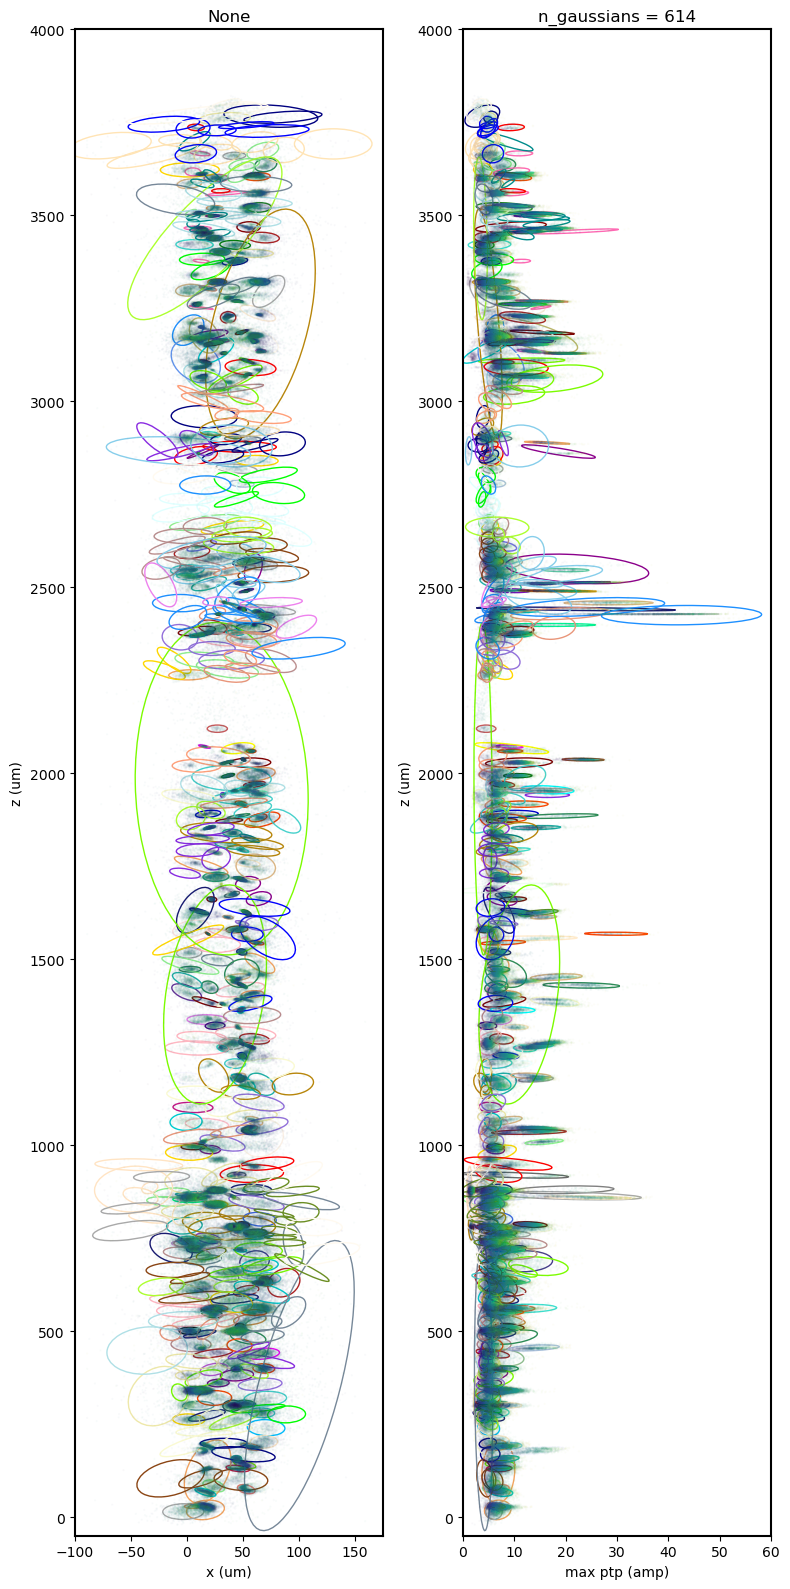

In [57]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, post_split_labels, post_split_labels, display_all_spikes=False, n_spikes_display=5_000)

now try decoding this new MoG after split-merge ...

In [58]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, post_split_labels, post_split_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 614, 30)
clusterless neural projections shape: (230, 614, 15)
clusterless neural reconstructions shape: (230, 614, 30)


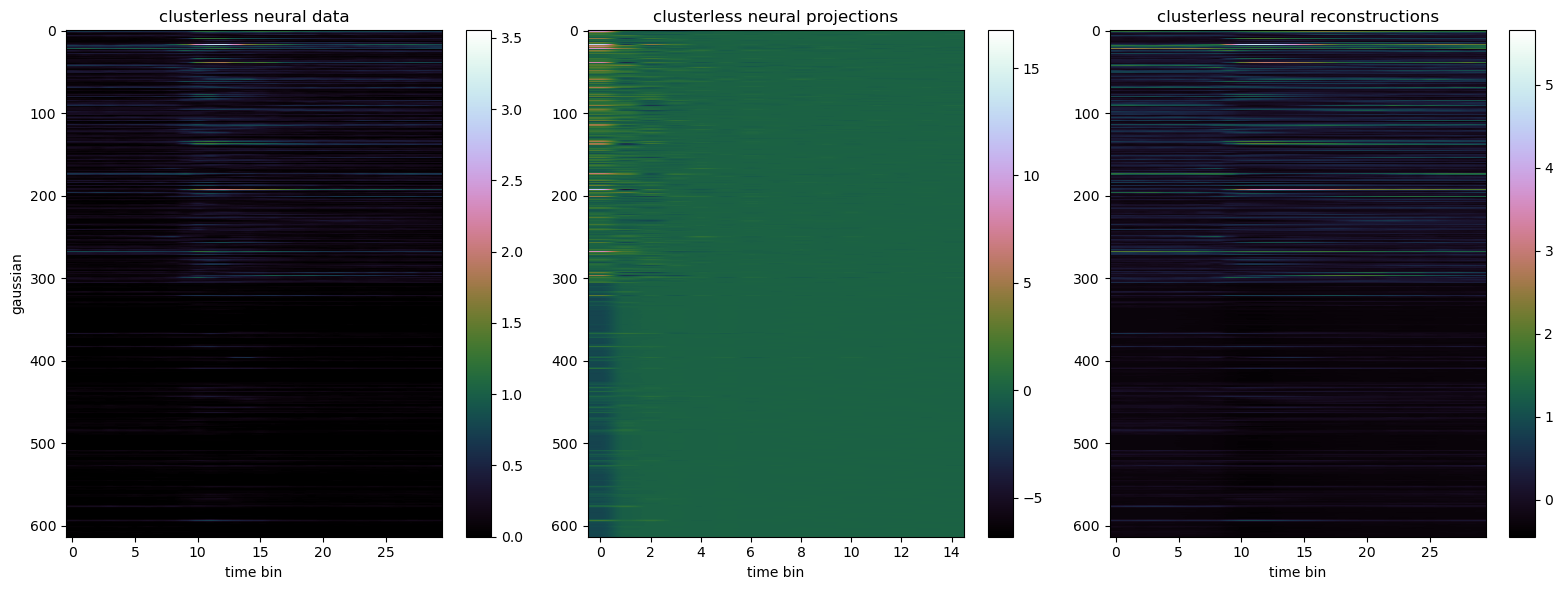

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [60]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.985
choice fold 2 test accuracy: 0.957 auc: 0.983
choice fold 3 test accuracy: 0.957 auc: 0.992
choice fold 4 test accuracy: 0.935 auc: 0.980
choice fold 5 test accuracy: 0.978 auc: 1.000
choice mean of 5-fold cv accuracy: 0.948 auc: 0.988
choice sd of 5-fold cv accuracy: 0.022 auc: 0.007
stimulus fold 1 test accuracy: 0.196 auc: 0.783
stimulus fold 2 test accuracy: 0.239 auc: 0.790
stimulus fold 3 test accuracy: 0.391 auc: 0.823
stimulus fold 4 test accuracy: 0.261 auc: 0.799
stimulus fold 5 test accuracy: 0.370 auc: 0.811
stimulus mean of 5-fold cv accuracy: 0.291 auc: 0.801
stimulus sd of 5-fold cv accuracy: 0.076 auc: 0.015


it looks like the large gaussians really have very low weights, \
so we can probably keep them as large gaussians since they contribute little to decoding. \
also, split-merge may not be ideal for clusterless decoding since \
we would want to avoid hard sorting and simply learn a mapping from spike features to weights. \
maybe we should choose a MoG that best describes the spike features data instead of \
a MoG that recovers spike sorting results by eye-balling? 

to do: visualize heat map of feature importance of MoG weights to see the contribution of large gaussians to decoding. 
https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn/67910281#67910281

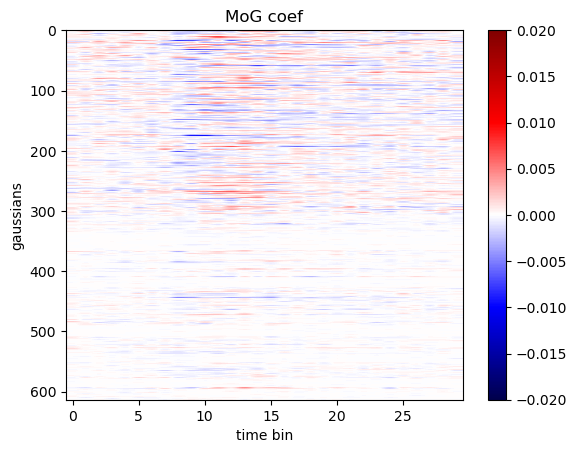

In [61]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()

merge (use kl divergence as criteria)